<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#RecA-deep-mutational-scanning-libraries" data-toc-modified-id="RecA-deep-mutational-scanning-libraries-1">RecA deep mutational scanning libraries</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span></li><li><span><a href="#Target-amplicon" data-toc-modified-id="Target-amplicon-1.2">Target amplicon</a></span></li><li><span><a href="#PacBio-CCSs" data-toc-modified-id="PacBio-CCSs-1.3">PacBio CCSs</a></span></li><li><span><a href="#Align-CCSs-to-target" data-toc-modified-id="Align-CCSs-to-target-1.4">Align CCSs to target</a></span></li><li><span><a href="#Parse-alignments" data-toc-modified-id="Parse-alignments-1.5">Parse alignments</a></span></li><li><span><a href="#Align-and-parse-several-sets-of-CCSs" data-toc-modified-id="Align-and-parse-several-sets-of-CCSs-1.6">Align and parse several sets of CCSs</a></span></li></ul></li></ul></div>

# RecA deep mutational scanning libraries
This example shows how to process PacBio circular consensus sequencing of a barcoded library of RecA variants for deep mutational scanning.
Note it just uses a snippet of the full data set of circular consensus sequences so that the example is small and fast.

## Set up for analysis
Import necessary Python modules.
We use `alignparse` for most of the operations, [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting, and [pysam](https://pysam.readthedocs.io) for handling SAM files:

In [1]:
import os
import warnings

import pandas as pd

from plotnine import *

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of an amplicon that includes the RecA gene along with barcodes and several other features.
The amplicon is defined as a Genbank file.
First, let's just look at that file.
Note the way that it defines the features; this is how they must be defined to be handled by `alignparse`.
Note also how there are ambiguous nucleotides in the barcode and variant tag regions:

In [4]:
recA_targetfile = 'input_files/recA_amplicon.gb'

with open(recA_targetfile) as f:
    print(f.read())

LOCUS       RecA_PacBio_amplicon    1342 bp ds-DNA     linear       06-AUG-2018
DEFINITION  PacBio amplicon for deep mutational scanning of E. coli RecA.
ACCESSION   None
VERSION     
SOURCE      Danny Lawrence
  ORGANISM  .
COMMENT     PacBio amplicon for RecA libraries.
COMMENT     There are single nucleotide tags in the 5' and 3' termini to measure strand exchange.
FEATURES             Location/Qualifiers
     termini5        1..147
                     /label="termini 5' of gene"
     gene            148..1206
                     /label="RecA gene"
     spacer          1207..1285
                     /label="spacer between gene & barcode"
     barcode         1286..1303
                     /label="18 nucleotide barcode"
     termini3        1304..1342
                     /label="termini 3' of barcode"
     variant_tag5    33..33
                     /label="5' variant tag"
     variant_tag3    1311..1311
                     /label="3' variant tag"
ORIGIN
        1 gcacggcgtc ac

Along with the Genbank file giving the sequence of the amplicon, we have a YAML file specifying how we filter and parse alignments to this amplicon.
Below is the text of the YAML file.

It tells us how well alignments must match the target before we filter them.
The query clipping indicates how much of the query is clipped at each end prior to the alignment, and for each feature it indicates how much clipping is allowed as well as the number of mutated nucleotides and mutation "operations" (independent indels or single-nucleotide substitutions) are allowed.
Below the mutation operation filter is all set to `null`, meaning that no filter is applied for these.
When filters are missing for a feature, they are automatically set to zero.

It also tells us what information we want to return from alignments that are not filtered.
In some cases we return nothing, in other cases we return the mutations or the the full sequence of the feature:

In [5]:
recA_parse_specs_file = 'input_files/recA_feature_parse_specs.yaml'
with open(recA_parse_specs_file) as f:
    print(f.read())

RecA_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
    return: mutations
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
  barcode:
    filter:
      mutation_nt_count: 0
      mutation_op_count: null
    return: sequence
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
  variant_tag5:
    return: sequence
  variant_tag3:
    return: sequence



We now read the amplicon into a `Targets` object with the feature-parsing specs:

In [6]:
targets = alignparse.targets.Targets(
                seqsfile=recA_targetfile,
                feature_parse_specs=recA_parse_specs_file)

We can plot the `Targets` object:

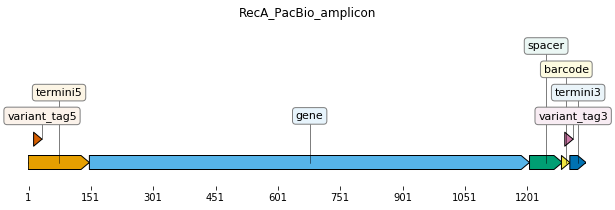

In [7]:
_ = targets.plot(ax_width=10)

We can also look at the featue parsing specifications as a dict or YAML string (here we do it as YAML string).
Note that all the defaults that were not specified in the YAML file above have now been filled in:

In [8]:
print(targets.feature_parse_specs('yaml'))

RecA_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  barcode:
    filter:
      mutation_nt_count: 0
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - sequence
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []
  variant_tag5:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag3:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0



## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile recA_lib-1_report.txt \
        --polish --numThreads 16 \
        recA_lib-1_subreads.bam lib-1_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with flags to retain the number of passes (`np`) and read quality (`rq`) flags:

    samtools bam2fq -T np,rq lib-1_ccs.bam > lib-1_ccs.fastq
    
Here is a data frame with the resulting FASTQ and BAM files:

In [9]:
run_names = ['recA_lib-1', 'recA_lib-2']
libraries = ['lib-1', 'lib-2']
ccs_dir = 'input_files'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'library': libraries,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

pacbio_runs

,name,library,report,fastq
0,recA_lib-1,lib-1,input_files/recA_lib-1_report.txt,input_files/recA_lib-1_ccs.fastq
1,recA_lib-2,lib-2,input_files/recA_lib-2_report.txt,input_files/recA_lib-2_ccs.fastq


We create a `Summaries` object for these CCSs:

In [10]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

Plot how many ZMWs yielded CCSs:

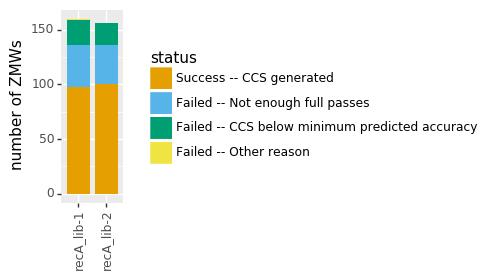

In [11]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

Statistics on the CCSs (length, number of subread passes, quality):

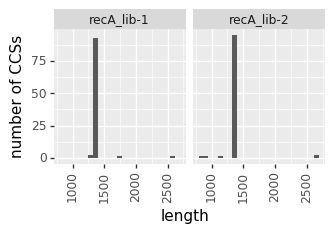

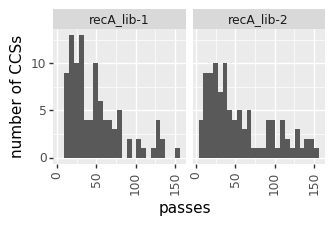

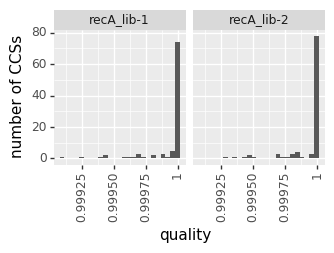

In [12]:
for stat in ['length', 'passes', 'quality']:
    p = ccs_summaries.plot_ccs_stats(stat)
    _ = p.draw()

## Align CCSs to target
Now we use `minimap2` to align the CCSs to the target.

First, we create a `Mapper` object to run `minimap2`, using the options for codon-level deep mutational scanning:

In [13]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --score-N=4 --secondary=no --cs


Now use the mapper to actually align the FASTQ queries to the target.
We'll do this just for the first PacBio run:

In [14]:
first_fastq = pacbio_runs.ix[0, 'fastq']
alignmentfile = os.path.join(outdir, 'alignment.sam')
print(f"Aligning {first_fastq} to create {alignmentfile}")
targets.align(queryfile=first_fastq,
              alignmentfile=alignmentfile,
              mapper=mapper)

Aligning input_files/recA_lib-1_ccs.fastq to create ./output_files/alignment.sam


These SAM files now contain the alignments along with the `minimap2`-generated [`cs` tag](https://github.com/lh3/minimap2#cs), which contains details on the mutations.
Here is an example of the `cs` tag:

In [15]:
with pysam.AlignmentFile(alignmentfile) as f:
    a = next(f)
    print(f"`cs` tag of first alignment in {alignmentfile}:\n" + 
          a.get_tag('cs'))

`cs` tag of first alignment in ./output_files/alignment.sam:
:32*ng:234*ag*tg*cg:93+a:268+a:416*ca*at*gt:235*ng*ng*nt*nc*na*nc*nt*na*ng*ng*ng*na*ng*na*ng*nc*nt*nt:7*nc:31


## Parse alignments
We can use `Targets.parse_alignments` to parse the SAM files to get the information we specified for return using `feature_parse_specs`.
This function returns a data frames (`readstats`) on the overall parsing stats, plus dicts keyed by the names of each target in `Targets` giving data frames on the aligned and filtered reads:

In [16]:
readstats, aligned, filtered = targets.parse_alignment(alignmentfile)

Lets look at the read stats:

In [17]:
readstats

,category,count
0,aligned RecA_PacBio_amplicon,83
1,filtered RecA_PacBio_amplicon,17
2,unmapped,0


We have parsed alignments and filtering information for each target (in this case there is just one target).
Let's look at the first few lines of those data frames:

In [18]:
for target in targets.target_names:
    print(f"First few lines of parsed alignments for {target}")
    display(aligned[target].head())
    print(f"First few lines of filtering information for {target}")
    display(filtered[target].head())

First few lines of parsed alignments for RecA_PacBio_amplicon


,query_name,query_clip5,query_clip3,gene_mutations,barcode_sequence,variant_tag5_sequence,variant_tag3_sequence
0,m54228_181120_212724/4194370/ccs,0,0,A121G T122G C123G ins217A ins485A C901A A902T ...,GGTCACTAGGGAGAGCTT,G,C
1,m54228_181120_212724/4194376/ccs,0,0,A937T A938T C939A,ACCAGTGTTTGCAGGATC,G,C
2,m54228_181120_212724/4194377/ccs,0,0,G112A T113A G114A G643T C644G,ATAAACCTAAACGCAGTA,G,C
3,m54228_181120_212724/4194382/ccs,0,0,ins116A A148T T149G A965C ins1043A,AGACTGACCAACAGGAAG,A,T
4,m54228_181120_212724/4194386/ccs,0,0,A895C T896C C897T G930A,AACCCAACTGTAAAGGCG,G,C


First few lines of filtering information for RecA_PacBio_amplicon


,query_name,filter_reason
0,m54228_181120_212724/4194398/ccs,query_clip5
1,m54228_181120_212724/4194398/ccs,termini5 clip5
2,m54228_181120_212724/4194406/ccs,gene mutation_nt_count
3,m54228_181120_212724/4194489/ccs,barcode mutation_nt_count
4,m54228_181120_212724/4194541/ccs,barcode mutation_nt_count


We can see that data frames in `aligned` give the information we want in a nice format.
The mutations to the gene are indicated in human readable form (with **1**-based numbering of the gene feature), and we have the sequence of the barcode and the variant tags.

The alignment data frames like the ones shown above should be the starting point for your downstream analysis, which will obviously be customized based on what you want to do.

## Align and parse several sets of CCSs
The examples above show how to use `Targets.align` and `Targets.parse_alignments` to align and parse a single set of queries.
But often we may have several sets of CCSs, such as from multiple PacBio runs.
In that case, `Targets.align_and_parse` can be used to automate the process of aligning and parsing all these sets and then aggregating the results.

First, we define a directory to place the created files:

In [19]:
align_and_parse_outdir = os.path.join(outdir, 'RecA_align_and_parse')

Now we run `Targets.align_and_parse` on all the CCS sets in `pacbio_runs`:

In [20]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        group_cols=['library'],
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

Now we can see that the read stats are provided for each run:

In [21]:
readstats

,library,name,category,count
0,lib-1,recA_lib-1,aligned RecA_PacBio_amplicon,83
1,lib-1,recA_lib-1,filtered RecA_PacBio_amplicon,17
2,lib-1,recA_lib-1,unmapped,0
3,lib-2,recA_lib-2,aligned RecA_PacBio_amplicon,86
4,lib-2,recA_lib-2,filtered RecA_PacBio_amplicon,16
5,lib-2,recA_lib-2,unmapped,0


And likewise for the information on the parsed alignments and filtered reads:

In [22]:
for target in targets.target_names:
    print(f"First few lines of parsed alignments for {target}")
    display(aligned[target].head())
    print(f"First few lines of filtering information for {target}")
    display(filtered[target].head())

First few lines of parsed alignments for RecA_PacBio_amplicon


,library,name,query_name,query_clip5,query_clip3,gene_mutations,barcode_sequence,variant_tag5_sequence,variant_tag3_sequence
0,lib-1,recA_lib-1,m54228_181120_212724/4194370/ccs,0,0,A121G T122G C123G ins217A ins485A C901A A902T ...,GGTCACTAGGGAGAGCTT,G,C
1,lib-1,recA_lib-1,m54228_181120_212724/4194376/ccs,0,0,A937T A938T C939A,ACCAGTGTTTGCAGGATC,G,C
2,lib-1,recA_lib-1,m54228_181120_212724/4194377/ccs,0,0,G112A T113A G114A G643T C644G,ATAAACCTAAACGCAGTA,G,C
3,lib-1,recA_lib-1,m54228_181120_212724/4194382/ccs,0,0,ins116A A148T T149G A965C ins1043A,AGACTGACCAACAGGAAG,A,T
4,lib-1,recA_lib-1,m54228_181120_212724/4194386/ccs,0,0,A895C T896C C897T G930A,AACCCAACTGTAAAGGCG,G,C


First few lines of filtering information for RecA_PacBio_amplicon


,library,name,query_name,filter_reason
0,lib-1,recA_lib-1,m54228_181120_212724/4194398/ccs,query_clip5
1,lib-1,recA_lib-1,m54228_181120_212724/4194398/ccs,termini5 clip5
2,lib-1,recA_lib-1,m54228_181120_212724/4194406/ccs,gene mutation_nt_count
3,lib-1,recA_lib-1,m54228_181120_212724/4194489/ccs,barcode mutation_nt_count
4,lib-1,recA_lib-1,m54228_181120_212724/4194541/ccs,barcode mutation_nt_count


Plot the read stats:

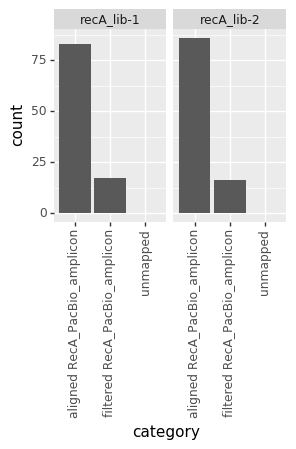

In [23]:
p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5)
          )
    )
_ = p.draw()

Plot the various reasons reads were filtered:

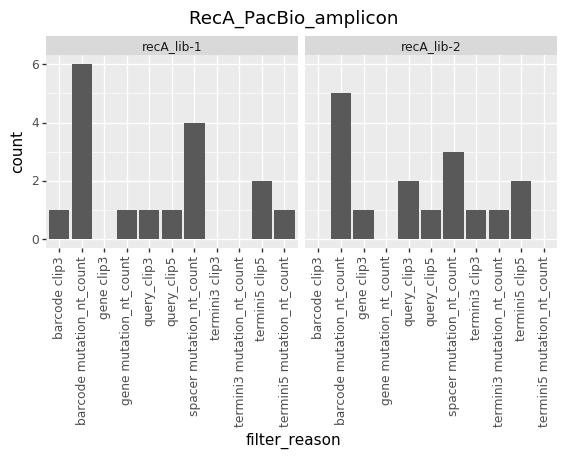

In [24]:
for targetname in targets.target_names:
    target_filtered = filtered[targetname]
    nreasons = target_filtered['filter_reason'].nunique()
    p = (
        ggplot(target_filtered, aes('filter_reason')) +
        geom_bar() +
        facet_wrap('~ name', nrow=1) +
        labs(title=targetname) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(0.3 * nreasons * len(pacbio_runs), 2.5),
              )
        )
    _ = p.draw()

We can also look at all the files created by running `Targets.align_and_parse`, which include the SAM alignments and parsing results for each run:

In [25]:
print(f"Contents of {align_and_parse_outdir}:\n" + '-' * 48)
for d, _, fs in os.walk(align_and_parse_outdir):
    for f in fs:
        print('  ' + os.path.relpath(os.path.join(d, f),
                                     align_and_parse_outdir))

Contents of ./output_files/RecA_align_and_parse:
------------------------------------------------
  RecA_PacBio_amplicon_aligned.csv
  RecA_PacBio_amplicon_filtered.csv
  lib-1_recA_lib-1/alignments.sam
  lib-1_recA_lib-1/RecA_PacBio_amplicon_aligned.csv
  lib-1_recA_lib-1/RecA_PacBio_amplicon_filtered.csv
  lib-2_recA_lib-2/alignments.sam
  lib-2_recA_lib-2/RecA_PacBio_amplicon_aligned.csv
  lib-2_recA_lib-2/RecA_PacBio_amplicon_filtered.csv


The above example read all of the information on the parsed alignments into data frames.
For large data sets, these data frames might be very large.
If you don't want to read them into memory, then use the `to_csv` option.
In that case, the returned values from `Targets.align_and_parse` simply gives the locations of CSV files with the information in the data frames:

In [26]:
readstats_csv, aligned_csv, filtered_csv = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=align_and_parse_outdir,
        name_col='name',
        queryfile_col='fastq',
        group_cols=['library'],
        to_csv=True,
        overwrite=True,  # overwrite any existing output
        ncpus=-1,  # use all available CPUs
        )

Now the returned information on the parsed alignments and filtering just gives the locations of the CSV files:

In [27]:
print(aligned_csv)
print(filtered_csv)

{'RecA_PacBio_amplicon': './output_files/RecA_align_and_parse/RecA_PacBio_amplicon_aligned.csv'}
{'RecA_PacBio_amplicon': './output_files/RecA_align_and_parse/RecA_PacBio_amplicon_filtered.csv'}
